In [73]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
grouped = pd.read_csv('../tensorMaker/total.csv')

In [75]:
grouped.head(1)

,timeStamp,transactionEther,transactionEther_average,priceInDollar,priceInDollarLog,quant,nft_address,transaction,timeStamp-day
0,2021-08-29 08:25:04+00:00,0.045,0.045,145.332704,2.162363,1,0x18765ee2ab5d2ab4adf27f4209cb25b89372d61d,0x000000d2a0ffa635d8de87054e98a0345086174c62a4...,2021-08-29 00:00:00+00:00


In [3]:
meta = pd.read_csv("../tensorMaker/nftMetaData.csv")

In [4]:
grouped['timeStamp'] = pd.to_datetime(grouped['timeStamp'], utc=True)
grouped["timeStamp-day"] = grouped['timeStamp'].dt.floor('D')
grouped["nft_address"] = grouped["nft_address"].str.lower()

In [5]:
from scipy.stats import kurtosis
pivot_trades = pd.pivot_table(grouped, values="quant", index="timeStamp-day", columns="nft_address", aggfunc=np.sum)
pivot_mean_log = pd.pivot_table(grouped, values="priceInDollarLog", index="timeStamp-day", columns="nft_address", aggfunc=np.mean)
pivot_max_log = pd.pivot_table(grouped, values="priceInDollarLog", index="timeStamp-day", columns="nft_address", aggfunc=np.max)
pivot_change_in_trades = pd.pivot_table(grouped, values="quant", index="timeStamp-day", columns="nft_address", aggfunc=np.sum).rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
pivot_change_in_log_prices = pd.pivot_table(grouped, values="priceInDollarLog", index="timeStamp-day", columns="nft_address", aggfunc=np.mean).rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0])
pivot_kurt_log = pd.pivot_table(grouped, values="priceInDollarLog", index="timeStamp-day", columns="nft_address", aggfunc=kurtosis)

In [6]:
tensor = np.array([
    pivot_trades,
    pivot_max_log,
    pivot_change_in_trades,
    pivot_change_in_log_prices,
    pivot_kurt_log,
    pivot_mean_log
])

In [7]:
import numpy as np
import pandas as pd
from scipy.stats import kurtosis
clusterDataList = []
errorList = []
for series in range(tensor.shape[2]):
    clusterData = {}
    
    data = tensor[:,:, series]

    clusterData['nft']=pivot_trades.iloc[:,series].name
    clusterData['Length']=len(data[0,:][~np.isnan(data[0,:])])

    clusterData['changeSquared_trade']=np.mean(np.power(data[2,:][~np.isnan(data[2,:])],2))
    
    clusterData['changeSquared_price']=np.mean(np.power(data[3,:][~np.isnan(data[3,:])],2))
    clusterData['changeCube_price']=np.mean(np.power(data[3,:][~np.isnan(data[3,:])],3))

    for statisticsSeries in range(tensor.shape[0]):
        try:
            clusterData[statisticsSeries,'average'] =np.average(data[statisticsSeries,:][~np.isnan(data[statisticsSeries,:])])
            clusterData[statisticsSeries,'median'] =np.nanmedian(data[statisticsSeries,:])
            clusterData[statisticsSeries,'var'] =np.nanvar(data[statisticsSeries,:])
            clusterData[statisticsSeries,'mean'] = np.nanmean(data[statisticsSeries,:])
            clusterData[statisticsSeries,'std'] =np.nanstd(data[statisticsSeries,:])
            clusterData[statisticsSeries,'max'] =np.max(data[statisticsSeries,:][~np.isnan(data[statisticsSeries,:])])
            clusterData[statisticsSeries,'min'] =np.min(data[statisticsSeries,:][~np.isnan(data[statisticsSeries,:])])
            clusterData[statisticsSeries,'sum'] =np.sum(data[statisticsSeries,:][~np.isnan(data[statisticsSeries,:])])
            clusterData[statisticsSeries,'kurtosis'] = kurtosis(data[statisticsSeries,:][~np.isnan(data[statisticsSeries,:])])
            clusterDataList.append(clusterData)
        except Exception:
            continue
            # errorData = {}
            # errorData["Err"] = data[statisticsSeries,:][~np.isnan(data[statisticsSeries,:])]
            # errorList.append(errorData)
            
    
err = pd.DataFrame(errorList)
x = pd.DataFrame(clusterDataList)

c:\Users\Thoma\.conda\envs\nftProject\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Thoma\.conda\envs\nftProject\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\Thoma\.conda\envs\nftProject\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\Users\Thoma\.conda\envs\nftProject\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
<ipython-input-7-3682be0fe87c>:23: RuntimeWarning: Degrees of freedom <= 0 for slice.
  clusterData[statisticsSeries,'var'] =np.nanvar(data[statisticsSeries,:])
<ipython-input-7-3682be0fe87c>:24: RuntimeWarning: Mean of empty slice
  clusterData[statisticsSeries,'mean'] = np.nanmean(data[statis

In [8]:
X_dropped=x.drop_duplicates()

In [9]:
X_dropped = X_dropped.dropna(axis=0, how='any')

In [10]:
X_dropped =pd.merge(X_dropped, meta, on="nft")

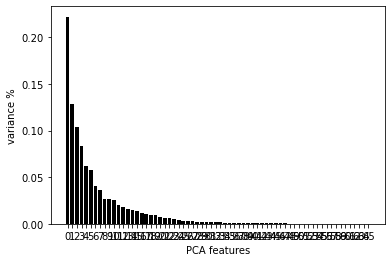

In [11]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

X = X_dropped.iloc[:,1:]
X_std = StandardScaler().fit_transform(X)

pca = PCA()
principalComponents = pca.fit_transform(X_std)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)

In [12]:
tSNE = TSNE(n_components=3)
tSNE_COMPS = tSNE.fit_transform(PCA_components)

tSNE_PCA_components = pd.DataFrame(tSNE_COMPS)

In [13]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

X = X_dropped.iloc[:,1:]
X_std = StandardScaler().fit_transform(X)

tSNE = TSNE(n_components=3)
tSNE_COMPS = tSNE.fit_transform(X_std)

tSNE = pd.DataFrame(tSNE_COMPS)

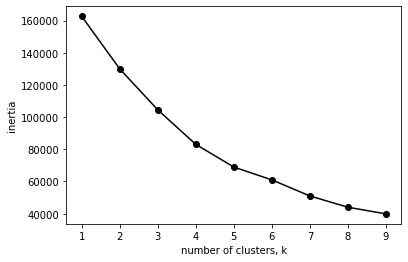

In [14]:
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:5])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

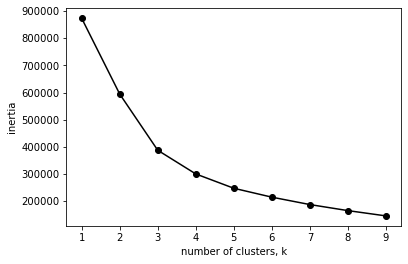

In [15]:
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(tSNE)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

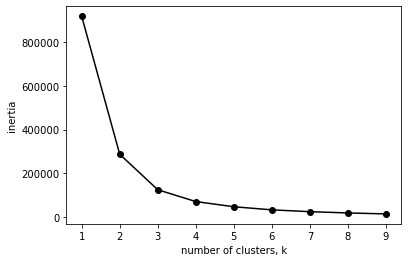

In [16]:
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    preds = model.fit_predict(tSNE_PCA_components)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_/k)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [17]:
# # Dendogram for Heirarchical Clustering
# import scipy.cluster.hierarchy as shc
# from matplotlib import pyplot
# pyplot.figure(figsize=(10, 7))  
# pyplot.title("Dendrograms")  
# dend = shc.dendrogram(shc.linkage(tSNE, method='ward'))

In [18]:
# # Dendogram for Heirarchical Clustering
# import scipy.cluster.hierarchy as shc
# from matplotlib import pyplot
# pyplot.figure(figsize=(10, 7))
# pyplot.title("Dendrograms")
# dend = shc.dendrogram(shc.linkage(PCA_components.iloc[:,:5], method='ward'))

In [19]:
# # Dendogram for Heirarchical Clustering
# import scipy.cluster.hierarchy as shc
# from matplotlib import pyplot
# pyplot.figure(figsize=(10, 7))
# pyplot.title("Dendrograms")
# dend = shc.dendrogram(shc.linkage(tSNE_PCA_components, method='ward'))

In [20]:
kmeanstSNE = KMeans(n_clusters=3)
labels = kmeanstSNE.fit_predict(tSNE)
X_dropped["labels-kmeans-tSNE"] = labels

In [21]:
kmeanstSNE = KMeans(n_clusters=3)
labels = kmeanstSNE.fit_predict(PCA_components.iloc[:,:5])
X_dropped["labels-kmeans-tSNEPCA-5-4"] = labels

In [22]:
kmeanstSNE = KMeans(n_clusters=3)
labels = kmeanstSNE.fit_predict(tSNE_PCA_components)
X_dropped["labels-kmeans-tSNEPCA"] = labels

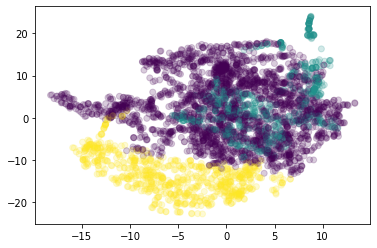

In [23]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(linkage="ward", n_clusters=3)
labelsAgglotSNE = clustering.fit_predict(tSNE)

X_dropped["labels-Agglo-tSNE"] = labelsAgglotSNE

plt.scatter(tSNE[0], tSNE[2], c=labelsAgglotSNE, alpha=.2)
plt.show()

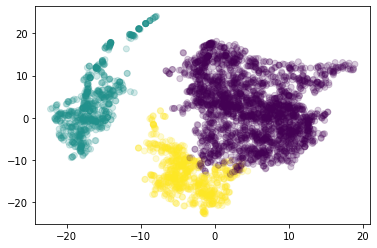

In [24]:
plt.scatter(tSNE[1], tSNE[2], c=labelsAgglotSNE, alpha=.2)
plt.show()

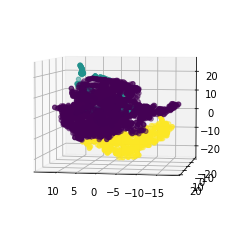

In [25]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(tSNE[0], tSNE[1], tSNE[2], c=labelsAgglotSNE, alpha=.5)
ax.view_init(elev=5., azim=100)

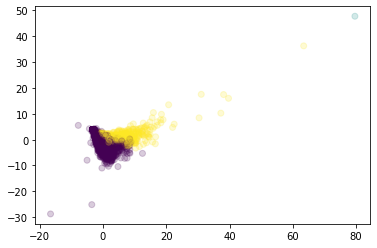

In [26]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(linkage="ward", n_clusters=3)
labelsAggloPCA = clustering.fit_predict(PCA_components.iloc[:,:5])

X_dropped["labels-Agglo-PCA"] = labelsAggloPCA

plt.scatter(PCA_components[0], PCA_components[1], c=labelsAggloPCA, alpha=.2)
plt.show()

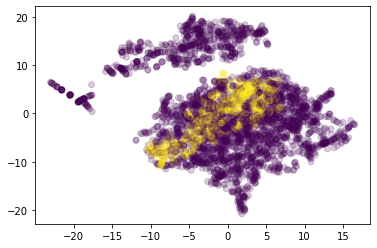

In [52]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(linkage="ward", n_clusters=2)
labelsAgglotSNEPCA = clustering.fit_predict(tSNE_PCA_components)

X_dropped["labels-Agglo-tSNEPCA-2"] = labelsAgglotSNEPCA

plt.scatter(tSNE_PCA_components[0], tSNE_PCA_components[1], c=labelsAgglotSNEPCA, alpha=.2)
plt.show()

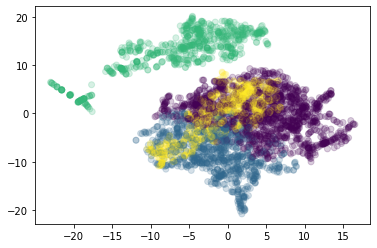

In [53]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(linkage="ward", n_clusters=4)
labelsAgglotSNEPCA4 = clustering.fit_predict(tSNE_PCA_components)

X_dropped["labels-Agglo-tSNEPCA-4"] = labelsAgglotSNEPCA4

plt.scatter(tSNE_PCA_components[0], tSNE_PCA_components[1], c=labelsAgglotSNEPCA4, alpha=.2)
plt.show()

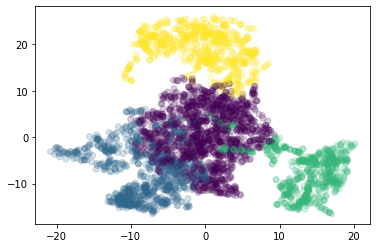

In [54]:
plt.scatter(tSNE_PCA_components[1], tSNE_PCA_components[2], c=labelsAgglotSNEPCA4, alpha=.2)
plt.show()

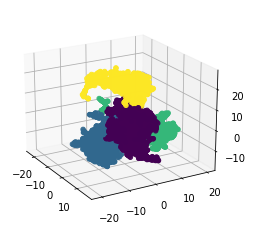

In [57]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(tSNE_PCA_components[0], tSNE_PCA_components[1], tSNE_PCA_components[2], c=labelsAgglotSNEPCA4, alpha=.9)
ax.view_init(elev=20., azim=330)

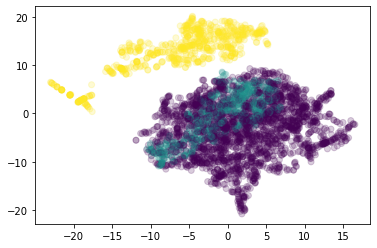

In [41]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(linkage="ward", n_clusters=3)
labelsAgglotSNEPCA = clustering.fit_predict(tSNE_PCA_components)

X_dropped["labels-Agglo-tSNEPCA-3"] = labelsAgglotSNEPCA

plt.scatter(tSNE_PCA_components[0], tSNE_PCA_components[1], c=labelsAgglotSNEPCA, alpha=.2)
plt.show()

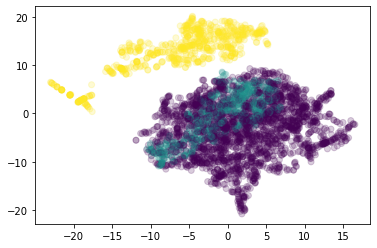

In [28]:
plt.scatter(tSNE_PCA_components[0], tSNE_PCA_components[1], c=labelsAgglotSNEPCA, alpha=.2)
plt.show()

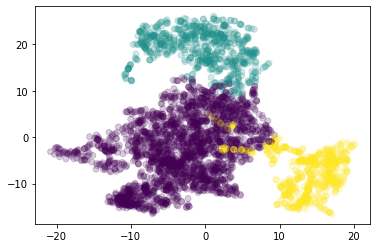

In [29]:
plt.scatter(tSNE_PCA_components[1], tSNE_PCA_components[2], c=labelsAgglotSNEPCA, alpha=.2)
plt.show()

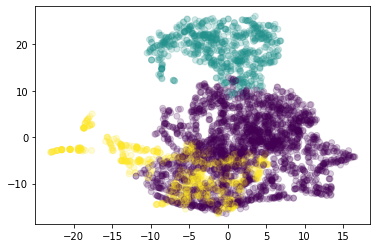

In [30]:
plt.scatter(tSNE_PCA_components[0], tSNE_PCA_components[2], c=labelsAgglotSNEPCA, alpha=.2)
plt.show()

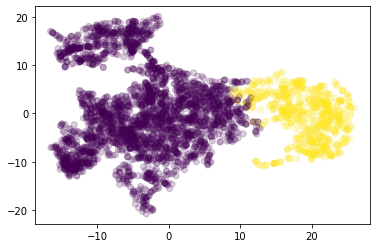

In [31]:
plt.scatter(tSNE_PCA_components[2], tSNE_PCA_components[1], c=labelsAgglotSNEPCA==1, alpha=.2)
plt.show()

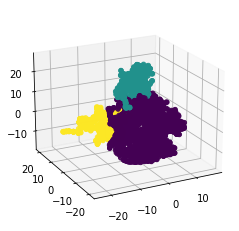

In [32]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(tSNE_PCA_components[0], tSNE_PCA_components[1], tSNE_PCA_components[2], c=labelsAgglotSNEPCA, alpha=.9)
ax.view_init(elev=20., azim=243)

In [33]:
nftAddressNames = pd.read_csv("../webscraper/nftNames-baseline.csv")

nftNames = dict(zip(nftAddressNames["addressBaselined"], nftAddressNames["name"]))
nftSymbol = dict(zip(nftAddressNames["addressBaselined"], nftAddressNames["symbol"]))


In [34]:
X_dropped["name"] = X_dropped["nft"].replace(nftNames)
X_dropped["symbol"] = X_dropped["nft"].replace(nftSymbol)

In [35]:
labels = X_dropped.iloc[:,67:73]
labels

,labels-kmeans-tSNE,labels-kmeans-tSNEPCA-5-4,labels-kmeans-tSNEPCA,labels-Agglo-tSNE,labels-Agglo-PCA,labels-Agglo-tSNEPCA
0,0,0,1,1,0,2
1,1,0,2,0,0,0
2,2,1,0,2,2,1
3,1,0,2,0,0,0
4,0,0,1,1,0,2
...,...,...,...,...,...,...
4103,1,0,2,0,0,0
4104,1,0,2,0,0,0
4105,0,0,1,1,0,2
4106,1,0,2,0,0,0


In [36]:
import numpy as np
import sklearn.metrics as skMetrics
comparison = labels.shape[1]
comp_square = np.zeros((comparison,comparison))

for x in range(comparison):
    for y in range(comparison):
        comp_square[x][y] = skMetrics.adjusted_rand_score(labels.iloc[:,x], labels.iloc[:,y])

np.savetxt("modelComp.csv", comp_square, delimiter=",")

In [37]:
X_dropped.to_csv("total_with_labels.csv")

In [38]:

# # the histogram of the data
# n, bins, patches = plt.hist(X_dropped[X_dropped["labels-Agglo-tSNE"]==1].iloc[:,7])
# # n, bins, patches = plt.hist(X_dropped[X_dropped["labels-Agglo-tSNE"]==1]["changeSquared_trade"])

# plt.grid(True)
# plt.show()

In [63]:
valueCounted = pd.read_csv("counted.csv")


In [67]:
nftAddress = valueCounted.iloc[:200,0]

In [69]:
top200NFTs = X_dropped[X_dropped["nft"].isin(nftAddress)]

In [70]:
top200NFTs

,nft,Length,changeSquared_trade,changeSquared_price,changeCube_price,"(0, average)","(0, median)","(0, var)","(0, mean)","(0, std)",...,labels-kmeans-tSNEPCA-5-4,labels-kmeans-tSNEPCA,labels-Agglo-tSNE,labels-Agglo-PCA,labels-Agglo-tSNEPCA,name,symbol,labels-Agglo-tSNEPCA-3,labels-Agglo-tSNEPCA-2,labels-Agglo-tSNEPCA-4
100,0x05a46f1e545526fb803ff974c790acea34d1f2d6,41,7.098466e+05,0.205943,-4.131756e-02,561.341463,314.0,4.811808e+05,561.341463,693.671976,...,1,0,0,2,1,nadir,N,1,1,3
171,0x099a16f0414cb0cc0555d5f1f8140166462d39ff,13,2.224635e+06,0.177532,-4.156642e-02,1342.769231,455.0,4.342518e+06,1342.769231,2083.870886,...,1,0,0,2,1,0x099a16f0414cb0cc0555d5f1f8140166462d39ff,0x099a16f0414cb0cc0555d5f1f8140166462d39ff,1,1,3
314,0x12d2d1bed91c24f878f37e66bd829ce7197e4d14,18,6.768685e+05,0.159369,-2.863621e-02,887.277778,407.0,1.848198e+06,887.277778,1359.484535,...,1,0,0,2,1,0x12d2d1bed91c24f878f37e66bd829ce7197e4d14,0x12d2d1bed91c24f878f37e66bd829ce7197e4d14,1,1,3
363,0x15a2d6c2b4b9903c27f50cb8b32160ab17f186e2,47,1.281045e+06,1.110967,-3.847818e-01,169.468085,6.0,5.904450e+05,169.468085,768.404173,...,1,0,0,2,1,Goofy Oversized Optics People,GOOP,1,1,3
390,0x1710d860034b50177d793e16945b6a25c7d92476,18,1.332764e+06,0.080979,2.118020e-02,1127.000000,725.5,8.986756e+05,1127.000000,947.984998,...,1,0,0,2,1,0x1710d860034b50177d793e16945b6a25c7d92476,0x1710d860034b50177d793e16945b6a25c7d92476,1,1,3
432,0x1981cc36b59cffdd24b01cc5d698daa75e367e04,19,1.560285e+06,0.109433,-2.674871e-03,541.789474,246.0,8.519340e+05,541.789474,923.002685,...,1,0,0,2,1,0x1981cc36b59cffdd24b01cc5d698daa75e367e04,0x1981cc36b59cffdd24b01cc5d698daa75e367e04,1,1,3
440,0x1a2f71468f656e97c2f86541e57189f59951efe7,5,1.977790e+06,1.349963,3.054205e+00,1525.000000,1724.0,1.014137e+06,1525.000000,1007.043792,...,1,0,0,2,1,0x1a2f71468f656e97c2f86541e57189f59951efe7,0x1a2f71468f656e97c2f86541e57189f59951efe7,1,1,3
473,0x1c5ed03149b1fd5efe12828a660c7b892c111ba4,20,6.903453e+05,0.024604,8.075536e-04,451.350000,156.5,4.956023e+05,451.350000,703.990289,...,1,0,0,2,1,Outkast,OK,1,1,3
518,0x1f2403da6a03f989d3588f61c9a6c6dbf94061b7,16,4.215628e+06,0.303736,2.212680e-01,1367.687500,390.5,4.666092e+06,1367.687500,2160.113878,...,1,0,0,2,1,0x1f2403da6a03f989d3588f61c9a6c6dbf94061b7,0x1f2403da6a03f989d3588f61c9a6c6dbf94061b7,1,1,3
552,0x2106c00ac7da0a3430ae667879139e832307aeaa,41,5.414823e+05,0.314770,1.052952e-01,241.926829,35.0,3.210955e+05,241.926829,566.652920,...,1,0,0,2,1,Loopy Donuts,DONUT,1,1,3


In [59]:
import scipy.stats as scStat

setToCompare = "labels-Agglo-tSNE"
clusters = len(X_dropped[setToCompare].unique())


for i in range(clusters):
    normality_priceStab = scStat.normaltest(X_dropped[X_dropped[setToCompare]==i]["changeSquared_price"])
    print("Normality change price",normality_priceStab)
    print("mean change price",np.mean(X_dropped[X_dropped[setToCompare]==i]["changeSquared_price"]))
    print("")

    normality_priceStab = scStat.normaltest(X_dropped[X_dropped[setToCompare]==i]["changeSquared_trade"])
    print("Normality changetrade",normality_priceStab)
    print("")

    normality_priceStab = scStat.normaltest(X_dropped[X_dropped[setToCompare]==i].iloc[:,53])
    print("Normality meanlog price",normality_priceStab)
    print("")


    print("mean change trade",np.mean(X_dropped[X_dropped[setToCompare]==i]["changeSquared_trade"]))
    print("mean quant trade",np.mean(X_dropped[X_dropped[setToCompare]==i].iloc[:,8]))
    print("")

    for z in range(clusters):
        tTest = 0
        if i != z: 
            tTest = scStat.ttest_ind(X_dropped[X_dropped[setToCompare]==i]["changeSquared_price"],X_dropped[X_dropped[setToCompare]==z]["changeSquared_price"])
            print("Compare cluster change price", i, " against:", z, ":", tTest)
            print("")
            tTest = scStat.ttest_ind(X_dropped[X_dropped[setToCompare]==i]["changeSquared_trade"],X_dropped[X_dropped[setToCompare]==z]["changeSquared_trade"])
            print("Compare cluster change in trade", i, " against:", z, ":", tTest)
            print("")
            tTest = scStat.ttest_ind(X_dropped[X_dropped[setToCompare]==i].iloc[:,8],X_dropped[X_dropped[setToCompare]==z].iloc[:,8])
            print("Compare cluster quantity trade", i, " against:", z, ":", tTest)
            print("")
            tTest = scStat.ttest_ind(X_dropped[X_dropped[setToCompare]==i].iloc[:,53],X_dropped[X_dropped[setToCompare]==z].iloc[:,53])
            print("Compare cluster mean log price", i, " against:", z, ":", tTest)
            print("")
    print("")
    print("")
    print("")
    print("")

Normality change price NormaltestResult(statistic=1353.066536690944, pvalue=1.53226800617874e-294)
mean change price 0.1389909472782274

Normality changetrade NormaltestResult(statistic=3403.3890455551937, pvalue=0.0)

Normality meanlog price NormaltestResult(statistic=4346.422371207459, pvalue=0.0)

mean change trade 172110.70915235975
mean quant trade 100.13383225030346

Compare cluster change price 0  against: 1 : Ttest_indResult(statistic=-11.412472904270105, pvalue=1.0118122685128233e-29)

Compare cluster change in trade 0  against: 1 : Ttest_indResult(statistic=5.555995850881808, pvalue=2.935207476361099e-08)

Compare cluster quantity trade 0  against: 1 : Ttest_indResult(statistic=16.071543685318733, pvalue=2.0558313531971984e-56)

Compare cluster mean log price 0  against: 1 : Ttest_indResult(statistic=1.9116016415025434, pvalue=0.055996848119210886)





Normality change price NormaltestResult(statistic=7449.713981615629, pvalue=0.0)
mean change price 1.518087653674135

Normal